In [205]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
import sys
sys.path.append("../../Code")
import vader
import settings as s
import utils 
import seaborn as sns 
import afinns as af
import s140
import opinion_lexicon as op
import so_cal as sc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
reviews = pd.read_csv('reviews_with_sent.csv', index_col=0)

In [207]:
reviews.head()

,idReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated,afinn,vader,s140,opinion_bow,opinion_freq,Affin-sentence,Vader-sentence,opinion_bow-sentence,opinion_freq-sentence,so_cal,s140-sentence
201,439,247449510,2018-03-28,2635362,4484,5688,"Great value, easy to get to",N,6,1,en,1.0,en,0.857139,0,None,4.0,0.8555,2,0.500000,0.333333,[4.0],[0.8555],[0.5],[0.3333333333333333],2.750000,[2]
202,440,248421191,2018-03-31,179985958,4484,5688,Robin’s place was great. Very spacious and we ...,N,55,5,en,1.0,en,0.999995,0,NaN,5.0,0.8313,2,0.136364,0.072727,"[3.0, 1.0, -1.0, -1.0, 3.0]","[0.6249, 0.0, -0.0516, -0.1531, 0.6588]","[0.3333333333333333, 0.3333333333333333, 0.111...","[0.2, 0.1111111111111111, 0.04, 0.0, 0.1666666...",2.740000,"[2, 2, 2, 2, 2]"
203,441,22938,2010-01-03,61471,4989,7118,Good location - easy access to Times Square an...,N,40,5,en,1.0,en,0.999997,0,NaN,14.0,0.9758,4,0.230769,0.150000,"[4.0, 3.0, 2.0, 3.0, 2.0]","[0.7003, 0.7678, 0.4754, 0.6588, 0.3612]","[0.2857142857142857, 0.1, 0.5, 0.5, 0.2]","[0.2, 0.058823529411764705, 0.25, 0.5, 0.14285...",3.628571,"[2, 2, 2, 2, 2]"
204,442,234213,2011-04-21,446902,4989,7118,We had the best possible time in NYC and Russe...,N,88,8,en,1.0,en,0.999995,0,NaN,36.0,0.9936,4,0.294118,0.136364,"[4.0, 7.0, 2.0, 6.0, 3.0, 4.0, 3.0, 7.0]","[0.836, 0.8176, 0.6705, 0.7688, 0.6249, 0.5542...","[0.1111111111111111, 0.42857142857142855, 0.33...","[0.058823529411764705, 0.21428571428571427, 0....",3.307143,"[2, 2, 2, 2, 2, 2, 2, 2]"
205,443,264416,2011-05-15,540879,4989,7118,Three of us stayed at this place for a week- i...,N,43,4,en,1.0,en,0.999997,0,NaN,13.0,0.9516,4,0.230769,0.139535,"[9.0, 3.0, -1.0, 2.0]","[0.8807, 0.6249, -0.0258, 0.4199]","[0.4, 0.5, 0.0, 0.14285714285714285]","[0.23529411764705882, 0.3333333333333333, 0.0,...",2.785714,"[4, 2, 2, 2]"


# Afinn

In [208]:
reviews['afinn'].describe()

count    225484.000000
mean         11.917156
std           7.803583
min         -35.000000
25%           7.000000
50%          11.000000
75%          16.000000
max         116.000000
Name: afinn, dtype: float64

In [209]:
afinn_table = utils.create_normalised_table(reviews, 'afinn')

In [210]:
afinn_table.head(10)

,id,comments,afinn,afinn-norm,afinn-adj-1,afinn-adj-1-norm,afinn-adj-2,afinn-adj-2-norm
201,247449510,"Great value, easy to get to",4.0,0.258278,4.0,0.291667,4.0,0.380952
202,248421191,Robin’s place was great. Very spacious and we ...,5.0,0.264901,5.0,0.319444,5.0,0.396825
203,22938,Good location - easy access to Times Square an...,14.0,0.324503,14.0,0.569444,14.0,0.539683
204,234213,We had the best possible time in NYC and Russe...,36.0,0.470199,29.5,1.000000,36.0,0.888889
205,264416,Three of us stayed at this place for a week- i...,13.0,0.317881,13.0,0.541667,13.0,0.523810
206,843520,A great apartment in the perfect location. I w...,6.0,0.271523,6.0,0.347222,6.0,0.412698
207,993034,Russ is an amazing host and his awesome apartm...,13.0,0.317881,13.0,0.541667,13.0,0.523810
208,1119849,"The apartment was really nice, like in the pic...",8.0,0.284768,8.0,0.402778,8.0,0.444444
209,1129816,"Great location! It was stylish, fun and smell...",15.0,0.331126,15.0,0.597222,15.0,0.555556
210,1292160,"Russ was very nice with us, so was his neighbo...",6.0,0.271523,6.0,0.347222,6.0,0.412698


# Vader

In [211]:
reviews['vader'].describe()

count    225484.000000
mean          0.867408
std           0.226885
min          -0.996400
25%           0.864100
50%           0.940100
75%           0.971900
max           0.999600
Name: vader, dtype: float64

In [212]:
vader_table = utils.create_normalised_table(reviews, 'vader', True)

In [215]:
vader_table.head(10)

,id,comments,vader,vader-norm,trans_vader,trans_vader_norm,trans_vader-adj-1,trans_vader-adj-1-norm,trans_vader-adj-2,trans_vader-adj-2-norm
201,247449510,"Great value, easy to get to",0.8555,0.927806,1.809386,0.873141,1.809386,0.513999,1.809386,0.684755
202,248421191,Robin’s place was great. Very spacious and we ...,0.8313,0.915681,1.779288,0.853052,1.779288,0.437037,1.779288,0.634833
203,22938,Good location - easy access to Times Square an...,0.9758,0.988076,1.966731,0.978164,1.966731,0.916347,1.966731,0.945738
204,234213,We had the best possible time in NYC and Russe...,0.9936,0.996994,1.991147,0.994461,1.991147,0.978781,1.991147,0.986236
205,264416,Three of us stayed at this place for a week- i...,0.9516,0.975952,1.934016,0.956328,1.934016,0.832691,1.934016,0.891475
206,843520,A great apartment in the perfect location. I w...,0.8316,0.915832,1.779658,0.853299,1.779658,0.437983,1.779658,0.635447
207,993034,Russ is an amazing host and his awesome apartm...,0.9100,0.955110,1.879045,0.919637,1.879045,0.692126,1.879045,0.800297
208,1119849,"The apartment was really nice, like in the pic...",0.8304,0.915230,1.778178,0.852311,1.778178,0.434199,1.778178,0.632993
209,1129816,"Great location! It was stylish, fun and smell...",0.9689,0.984619,1.957348,0.971901,1.957348,0.892352,1.957348,0.930174
210,1292160,"Russ was very nice with us, so was his neighbo...",0.5170,0.758216,1.430977,0.620564,1.608376,0.000000,1.430977,0.057103


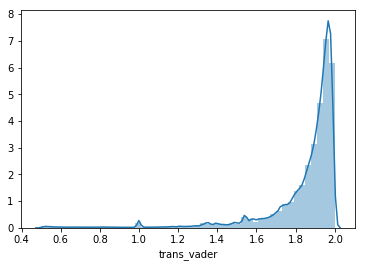

In [214]:
sns.distplot(vader_table['trans_vader'])
plt.show()

# S-140

In [216]:
utils.get_comments(reviews, 'id', 1292160, 'comments')

"Russ was very nice with us, so was his neighbour David. The flat is very well located, just a few blocks from the subway and Times square. The roof offers a nice view over the area and Manhattan buildings. It's not really spacious but eveything's in it."

In [180]:
val_set = set()
for i in reviews['Affin-sentence']:
    val_set = val_set.union(i.replace('[', '').replace(']', '').split(", "))

min = np.min([float(i) for i in val_set])
max = np.max([float(i) for i in val_set])